In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "pm25_7", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "chd2016", "dep2016", "adl2016", 
            "living2016", "division"]


df = pd.read_stata('../HeatResilience.dta', columns=read_cols)

In [3]:
categorical_cols = ['female', 'racethn', 'urban', 'mar_cat2', "psyche2016", "stroke2016", 
                    "hibpe2016", "diabe2016", "hearte2016",  'living2016', 'division',]
ordinal_cols = ["smoke2016",  'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016']
continuous_cols = ['eduy', 'ihs_wealthf2016', 'age2016', 'pmono','bmi2016', 'tractdis', 'chd2016', 'dep2016', 'adl2016', "pm25_7",
                    "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
for c in categorical_cols:
    df[c] = df[c].astype("category")
# categorical = [c for c in df.columns if df[c].dtype == "category"]
# separate binary vs multicategory cols
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats) # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats) # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols+ordinal_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [5]:
df.columns

Index(['zPCPhenoAge_acc', 'pm25_7', 'age2016', 'female', 'eduy',
       'ihs_wealthf2016', 'pmono', 'PNK_pct', 'PBcell_pct', 'PCD8_Plus_pct',
       'PCD4_Plus_pct', 'PNCD8_Plus_pct', 'smoke2016', 'drink2016', 'bmi2016',
       'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016',
       'diabe2016', 'hearte2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
       'chd2016', 'dep2016', 'adl2016', 'living2016', 'racethn_0. NHW',
       'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others',
       'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban',
       'division_Northeast', 'division_Midwest', 'division_South',
       'division_West'],
      dtype='object')

In [6]:
input_cols = ['female', 'eduy', 'ihs_wealthf2016', 'pmono', 'bmi2016', "age2016",
            'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
            'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
            'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016', # ordinals
            'racethn_0. NHW', 'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others', # multi cats
            'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
            'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
            "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
controlled_cols = [
    "pm25_7",
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = [
    "female", "racethn_0. NHW", "racethn_1. NHB", "racethn_2. Hispanic", "racethn_3. Others",
    'eduy', 'ihs_wealthf2016', 'bmi2016', 
    'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
    'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
    'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
    'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
    'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
]

In [7]:
# interactor
pm25_cont_np = df_norm["pm25_7"].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["zPCPhenoAge_acc"].to_numpy()

In [8]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3316


In [9]:
# split to train and test
train_idx, test_idx = train_test_split(num_elems, 0.7)
train_pm25_cont = pm25_cont_np[train_idx]
train_controlled_vars = controlled_vars_np[train_idx]
train_interaction_vars = interaction_vars_np[train_idx]
train_pheno_epi = pheno_epi_np[train_idx]

test_pm25_cont = torch.from_numpy(pm25_cont_np[test_idx].astype(np.float32))
test_controlled_vars = torch.from_numpy(controlled_vars_np[test_idx].astype(np.float32))
test_interaction_vars = torch.from_numpy(interaction_vars_np[test_idx].astype(np.float32))
test_pheno_epi = torch.from_numpy(pheno_epi_np[test_idx].astype(np.float32))

In [10]:
# create dataset
train_dataset = MIHMDataset(train_pm25_cont, train_controlled_vars, train_interaction_vars, train_pheno_epi)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

## Load model and train

In [11]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = MIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes, include_interactor_bias=False, dropout=0.5)

In [12]:
torch.manual_seed(0)
mseLoss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.1)
epochs = 500

In [13]:
model.eval()
with torch.no_grad():
    predicted_epi, predicted_index = model(test_interaction_vars, test_pm25_cont, test_controlled_vars)
    loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Testing Loss: {}".format(loss_test.item()))
early_stop_trigger_counter = 0
early_stop_tolerance = 0.2

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, sample in enumerate(dataloader):
        optimizer.zero_grad()
        # forward pass
        predicted_epi, predicted_index = model(sample["interaction_input_vars"], sample["interactor_var"], sample["controlled_vars"])
        label = torch.unsqueeze(sample["label"], 1)
        loss = mseLoss(predicted_epi, label)

        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print average loss for epoch
    epoch_loss = running_loss / len(dataloader)

    # evaluation on test set
    model.eval()
    with torch.no_grad():
        predicted_epi, predicted_interaction = model(test_interaction_vars, test_pm25_cont, test_controlled_vars)
        loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Epoch {}/{} done!".format(epoch+1, epochs))
    print("Training Loss: {}".format(epoch_loss))
    print("Testing Loss: {}".format(loss_test.item()))
    # early stopping
    if loss_test.item() > epoch_loss + early_stop_tolerance:
        early_stop_trigger_counter += 1
        if early_stop_trigger_counter > 5:
            print("Early stopping triggered!")
            break

/home/namj/miniconda3/envs/hrs/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([995])) that is different to the input size (torch.Size([995, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Testing Loss: 4.961288928985596
Epoch 1/500 done!
Training Loss: 8.606128414471945
Testing Loss: 4.649364471435547
Epoch 2/500 done!
Training Loss: 7.953260838985443
Testing Loss: 4.446926116943359
Epoch 3/500 done!
Training Loss: 8.099991083145142
Testing Loss: 4.269570827484131
Epoch 4/500 done!
Training Loss: 7.664976418018341
Testing Loss: 4.1307373046875
Epoch 5/500 done!
Training Loss: 6.405217965443929
Testing Loss: 4.015005588531494
Epoch 6/500 done!
Training Loss: 5.941045840581258
Testing Loss: 3.9171500205993652
Epoch 7/500 done!
Training Loss: 5.377009183168411
Testing Loss: 3.8145899772644043
Epoch 8/500 done!
Training Loss: 5.1767205993334455
Testing Loss: 3.7239327430725098
Epoch 9/500 done!
Training Loss: 4.918573011954625
Testing Loss: 3.6355395317077637
Epoch 10/500 done!
Training Loss: 5.025175998608272
Testing Loss: 3.5446622371673584
Epoch 11/500 done!
Training Loss: 4.543425053358078
Testing Loss: 3.468491554260254
Epoch 12/500 done!
Training Loss: 4.4094993770122

In [14]:
all_interaction_vars_tensor = torch.from_numpy(interaction_vars_np.astype(np.float32))
model.eval()
predicted_index = model.get_resilience_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().numpy()

(array([ 10.,  16.,  34.,  54.,  70., 117., 142., 169., 196., 177., 209.,
        261., 279., 305., 308., 256., 190., 143., 102.,  85.,  48.,  44.,
         39.,  28.,  10.,  13.,   4.,   3.,   2.,   2.]),
 array([-0.08139557, -0.05348667, -0.02557777,  0.00233114,  0.03024004,
         0.05814894,  0.08605785,  0.11396675,  0.14187565,  0.16978456,
         0.19769347,  0.22560236,  0.25351128,  0.28142017,  0.30932906,
         0.33723798,  0.36514688,  0.3930558 ,  0.42096469,  0.44887361,
         0.4767825 ,  0.50469142,  0.53260028,  0.5605092 ,  0.58841813,
         0.61632699,  0.64423591,  0.67214483,  0.70005375,  0.72796261,
         0.75587153]),
 <BarContainer object of 30 artists>)

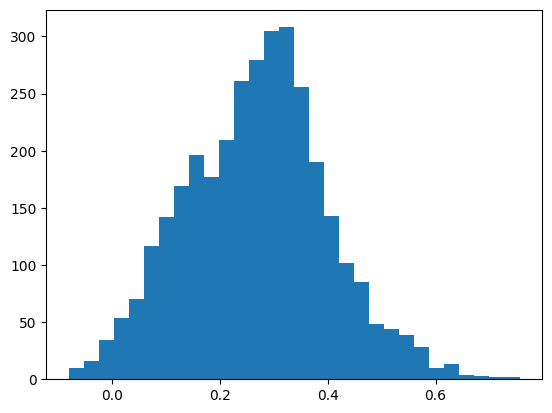

In [15]:
plt.hist(all_resilience_index, bins=30)

In [16]:
torch.save(model.state_dict(), "../checkpoints/Feb2_pm25_model_v3_nosp.pth")